In [63]:
#| echo: false

# Last updated
from datetime import datetime
from IPython import display

display.Markdown(f"*Last update: {datetime.today().strftime('%Y-%m-%d')}*")

*Last update: 2024-06-19*

In [64]:
#| echo: false

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns

from constants import EXPERIMENTS_DIR, PROCESSED_DIR, SEED
from utils.reports import (
    bootstrap_scores,
    compute_scores,
    load_supervised_metrics,
    load_predictions,
    plot_preds_scatter,
    plot_scores_bootstrap,
)

target_names = {
    "pm10": "$PM_{10}$",
    "pm10_imp": "$PM_{10}$",
    "op_aa25_m3": "$OP_{AA}$",
    "op_dtt25_m3": "$OP_{DTT}$",
}
target_units = {
    "pm10": "$\mu g/m^3$",
    "pm10_imp": "$\mu g/m^3$",
    "op_aa25_m3": "$nmol~min^{-1}~m^{-3}$",
    "op_dtt25_m3": "$nmol~min^{-1}~m^{-3}$",
}
splits_path = PROCESSED_DIR / "splits.csv"


# Function to plot train + val loss curves
def plot_loss(ax: Axes, data: pd.DataFrame):
    palette = sns.color_palette("Paired", 2)

    # Train + val
    ax.plot(data["epoch"], data["train_rmse"], lw=1, label="Training", color=palette[0])
    ax.plot(data["epoch"], data["val_rmse"], lw=1.5, label="Validation", color=palette[1])

    # Dotted lines to best epoch val
    best_idx = data["val_rmse"].argmin()
    best_val = data["val_rmse"].min()
    ax.plot([-2, best_idx], [best_val, best_val], dashes=(1, 1), color="black", alpha=0.5)
    ax.plot([best_idx, best_idx], [0, best_val], dashes=(1, 1), color="black", alpha=0.5)

    # Formatting
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(data.index[0], fontsize=10, y=1, pad=-10)

def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

# Introduction

Results of experiments using high-dimensional representation of meteorology to predict air quality.

# OP~AA~

In [65]:
# ------------------------
# Load and identify models
# ------------------------

# Load preds from all AA models
aa_preds = load_predictions(EXPERIMENTS_DIR / "embedding" / "op-aa25-m3").dropna()

# Simplify dataset and backbone names
aa_preds["dataset"] = aa_preds["dataset"].str.removesuffix("_PS2_clear")
aa_preds["backbone"] = aa_preds["backbone"].str.removesuffix("_RGB")

# Compress version
aa_preds["version"] = aa_preds["version"].str.replace("version_", "v")

# Identify models' CNN backbone
aa_preds = aa_preds.set_index(["dataset", "backbone", "experiment", "version"])
aa_preds["CNN"] = None
aa_preds.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
aa_preds.loc[pd.IndexSlice[:, "nocnn", "exp02", "v0"], "CNN"] = "None"
aa_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
aa_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"
aa_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp03", "v0"], "CNN"] = "Transfer"
aa_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp04", "v0"], "CNN"] = "Fine-tuning"
aa_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp05", "v0"], "CNN"] = "Transfer"

# Embedding
aa_preds["embedding"] = ""
aa_preds.loc[aa_preds["hparams"].str.contains("extra-2027"), "embedding"] = "met-d2-n512"
aa_preds.loc[aa_preds["hparams"].str.contains("extra-1976"), "embedding"] = "met-d3-n256"
aa_preds.loc[aa_preds["hparams"].str.contains("extra-3958"), "embedding"] = "met-d3-n512"

# Name models
aa_preds["model"] = aa_preds["CNN"].replace({"None": "Baseline"})
aa_preds["model"] = aa_preds["model"] + " " + aa_preds["embedding"]

# Ensure no unexpected models
if any(aa_preds["model"].isna()):
    missing = aa_preds.loc[
        aa_preds["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
aa_preds = (
    aa_preds.reset_index()
    .sort_values("station")
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "None", "met-d2-n512"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
            ("RGB", "Transfer", "met-d2-n512"),
            ("RGB", "Fine-tuning", "met-d2-n512"),
            ("RGB", "Transfer", "met-d3-n512"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# aa_preds.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["pred"]].count()

## Scores

In [66]:
#| label: tbl-aa-scores
#| tbl-cap: Scores of OP~AA~ embedded met models

target = "op_aa25_m3"
(
    aa_preds.groupby(["set", "dataset", "model"], sort=False, observed=True)
    .apply(compute_scores, true_col=target)
    .unstack("set")
    .reorder_levels(["set", 0], axis="columns")
    .loc[:, (["train", "val", "test"], ["R2", "RMSE", "NMAE"])]
    .style.format(precision=2)
    .format("{:.0%}", subset=pd.IndexSlice[:, pd.IndexSlice[:, "NMAE"]])
)

## Bootstrap

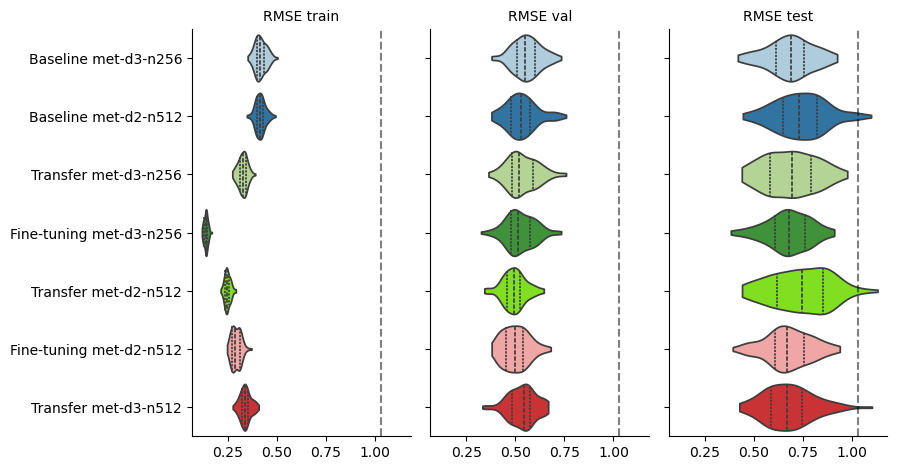

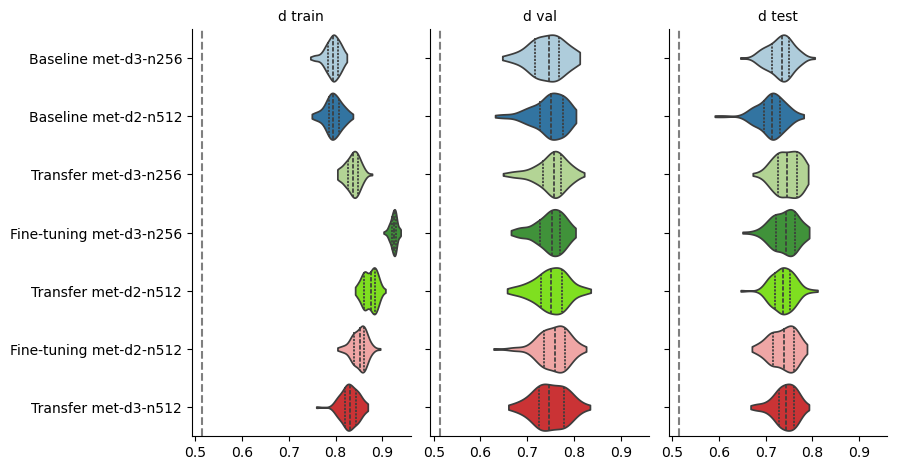

In [67]:
#| label: fig-aa-boots
#| fig-cap: Scores of OP~AA~ embedded met models (+ bootstrap 95% CI)
#| fig-subcap: true

target = "op_aa25_m3"
metrics = ["R2", "RMSE", "d"]
palette = sns.color_palette("Paired", 6)
p = plot_scores_bootstrap(
    aa_preds.loc["RGB"],
    true_col=target,
    by_model=True,
    scores=metrics,
    seed=SEED,
    kind="violin",
    palette=palette[0:4] + ["chartreuse"] + palette[4:]
)

In [68]:
#| label: tbl-aa-boots
#| tbl-cap: Bootstrap-estimated 95% CI of test set scores for OP~AA~ embedded met models

target = "op_aa25_m3"
(
    aa_preds.loc[aa_preds["set"].eq("test")]
    .loc["RGB"]
    .groupby("model", observed=True, sort=False)
    .apply(bootstrap_scores, true_col=target, n_boot=1000, seed=SEED)
    .groupby("model", observed=True, sort=False)
    .agg([q05, q95])[["R2", "RMSE", "NMAE", "d"]]
    .style.format(precision=2)
    .format("{:.0%}", subset="NMAE")
)

## Scatter

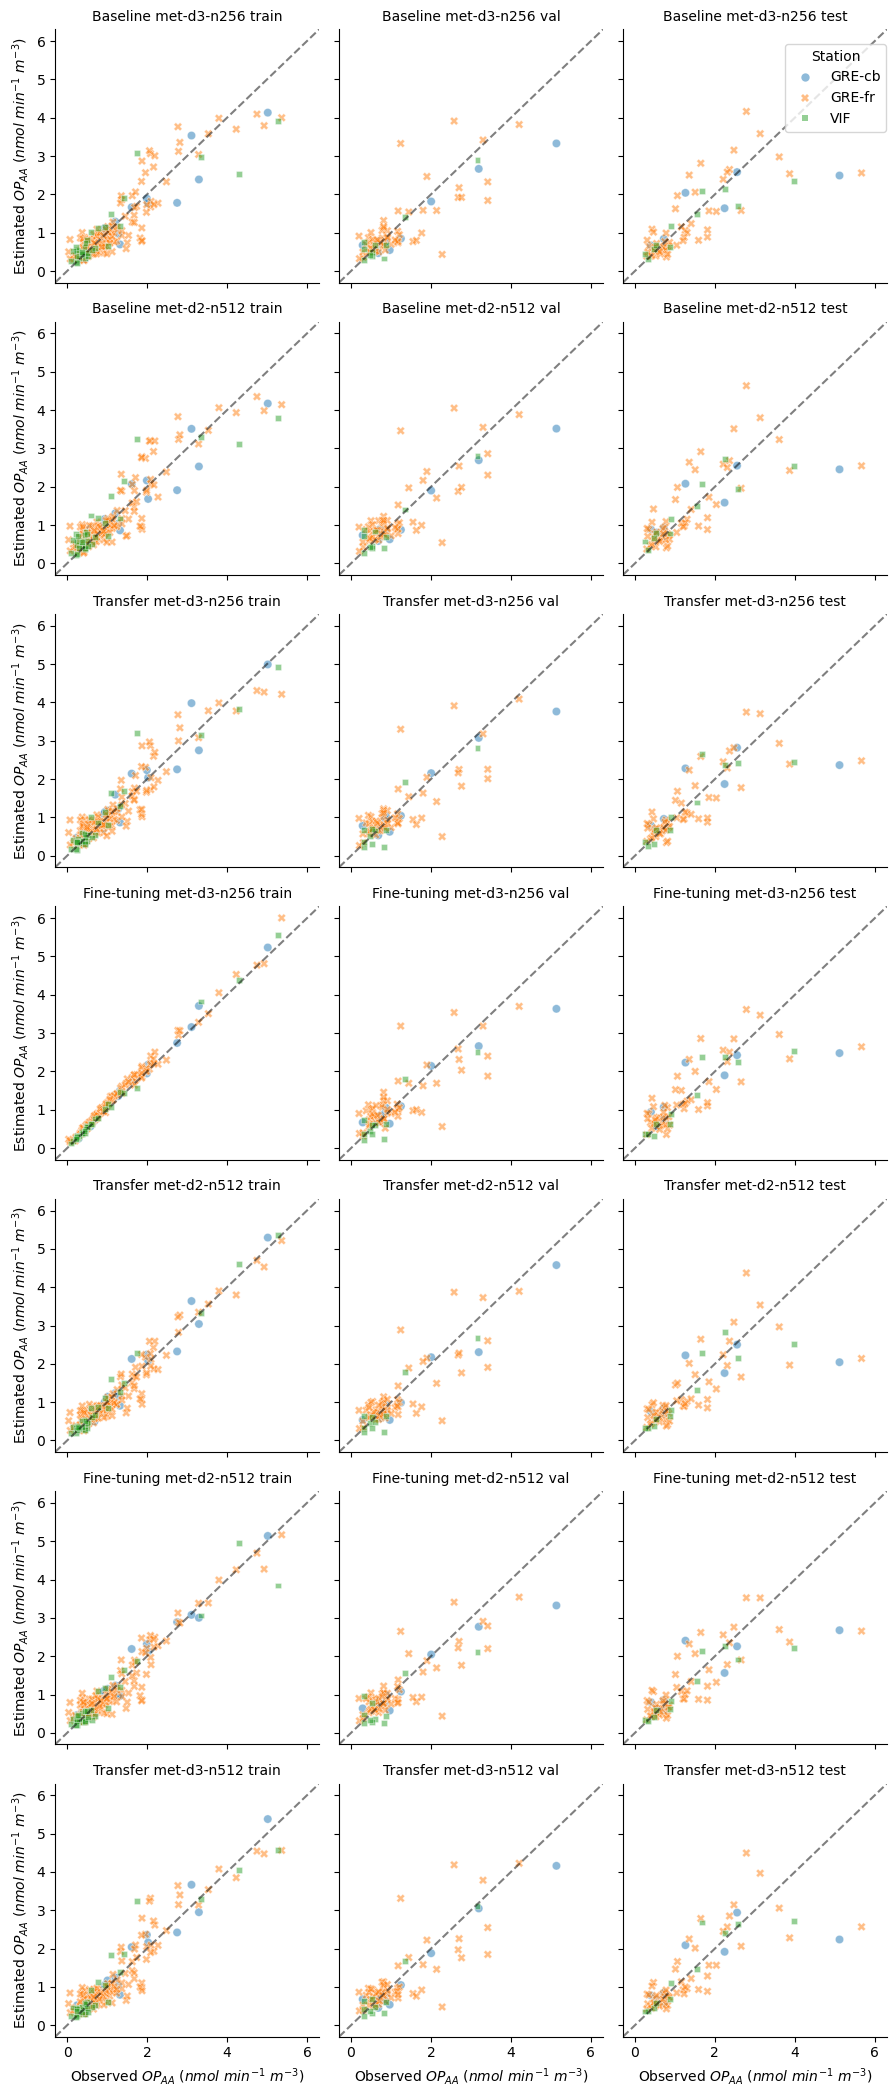

In [69]:
#| label: fig-aa-scatter
#| fig-cap: Observed and predicted OP~AA~ from embedded met models

target = "op_aa25_m3"
p = plot_preds_scatter(
    aa_preds,
    true_col=target,
    true_desc=f"{target_names[target]} ({target_units[target]})",
    row="model",
    facet_kws=dict(legend_out=False),
    legend=True,
)
p.legend.set(title="Station")
sns.move_legend(p, "upper right", bbox_to_anchor=(0.99, 0.98))

## Loss curves

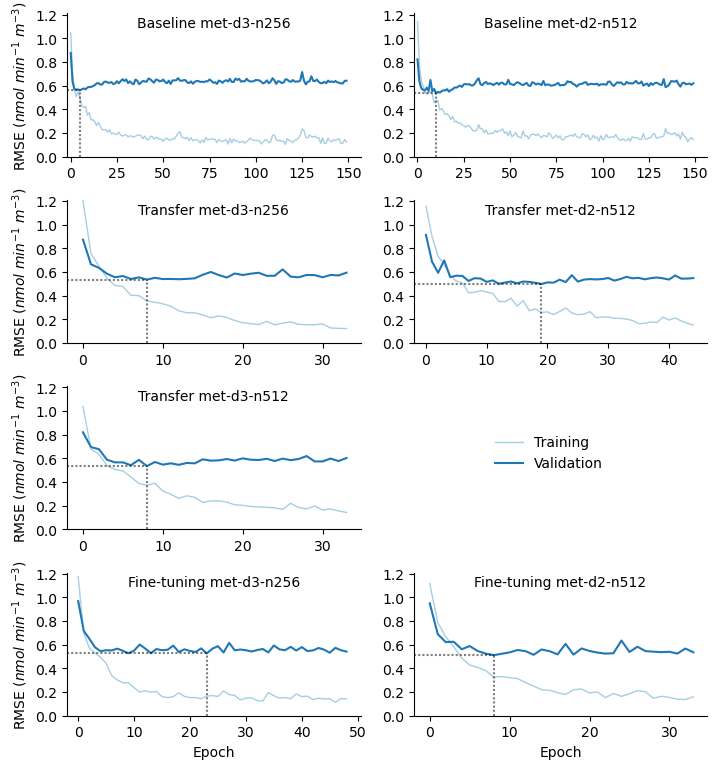

In [70]:
#| label: fig-aa-loss
#| fig-cap: Training and validation loss from OP~AA~ embedded met models

# Load training metrics
aa_loss = load_supervised_metrics(EXPERIMENTS_DIR / "embedding" / "op-aa25-m3")

# Simplify dataset and backbone names
aa_loss["dataset"] = aa_loss["dataset"].str.removesuffix("_PS2_clear")
aa_loss["backbone"] = aa_loss["backbone"].str.removesuffix("_RGB")

# Compress version
aa_loss["version"] = aa_loss["version"].str.replace("version_", "v")

# Identify models' CNN backbone
aa_loss = aa_loss.set_index(["dataset", "backbone", "experiment", "version"])
aa_loss["CNN"] = None
aa_loss.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
aa_loss.loc[pd.IndexSlice[:, "nocnn", "exp02", "v0"], "CNN"] = "None"
aa_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
aa_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"
aa_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp03", "v0"], "CNN"] = "Transfer"
aa_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp04", "v0"], "CNN"] = "Fine-tuning"
aa_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp05", "v0"], "CNN"] = "Transfer"

# Embedding
aa_loss["embedding"] = ""
aa_loss.loc[aa_loss["hparams"].str.contains("extra-2027"), "embedding"] = "met-d2-n512"
aa_loss.loc[aa_loss["hparams"].str.contains("extra-1976"), "embedding"] = "met-d3-n256"
aa_loss.loc[aa_loss["hparams"].str.contains("extra-3958"), "embedding"] = "met-d3-n512"

# Name models
aa_loss["model"] = aa_loss["CNN"].replace({"None": "Baseline"})
aa_loss["model"] = aa_loss["model"] + " " + aa_loss["embedding"]

# Ensure no unexpected models
if any(aa_loss["model"].isna()):
    missing = aa_loss.loc[
        aa_loss["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
aa_loss = (
    aa_loss.reset_index()
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "None", "met-d2-n512"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Transfer", "met-d2-n512"),
            ("RGB", "Transfer", "met-d3-n512"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d2-n512"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# aa_loss.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["val_loss"]].count()

# Plot
target = "op_aa25_m3"
data = aa_loss.set_index("model").sort_values("epoch")
fig, axs = plt.subplots(4, 2)

plot_loss(axs[0, 0], data.loc["Baseline met-d3-n256"])
plot_loss(axs[0, 1], data.loc["Baseline met-d2-n512"])
plot_loss(axs[1, 0], data.loc["Transfer met-d3-n256"])
plot_loss(axs[1, 1], data.loc["Transfer met-d2-n512"])
plot_loss(axs[2, 0], data.loc["Transfer met-d3-n512"])
axs[2, 1].set_axis_off()
plot_loss(axs[3, 0], data.loc["Fine-tuning met-d3-n256"])
plot_loss(axs[3, 1], data.loc["Fine-tuning met-d2-n512"])

for ax in axs[:, 0]:
    ax.set_ylabel(f"RMSE ({target_units[target]})")

for ax in axs[-1, :]:
    ax.set_xlabel("Epoch")

for i, ax in enumerate(axs.flatten()):
    ylim = (0, 1.21)
    ax.set(
        xlim=(-2, None), ylim=ylim, yticks=np.arange(*ylim, 0.2)
    )

fig.legend(handles=axs[0, 0].lines[0:2], frameon=False, bbox_to_anchor=(0.85, 0.45))

fig.set_figheight(7.8)
fig.set_figwidth(7.3)
fig.tight_layout()

del data

# OP~DTT~

In [71]:
# ------------------------
# Load and identify models
# ------------------------

# Load preds from all DTT models
dtt_preds = load_predictions(EXPERIMENTS_DIR / "embedding" / "op-dtt25-m3").dropna()

# Simplify dataset and backbone names
dtt_preds["dataset"] = dtt_preds["dataset"].str.removesuffix("_PS2_clear")
dtt_preds["backbone"] = dtt_preds["backbone"].str.removesuffix("_RGB")

# Compress version
dtt_preds["version"] = dtt_preds["version"].str.replace("version_", "v")

# Identify models' CNN backbone
dtt_preds = dtt_preds.set_index(["dataset", "backbone", "experiment", "version"])
dtt_preds["CNN"] = None
dtt_preds.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
dtt_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
dtt_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"

# Embedding
dtt_preds["embedding"] = ""
dtt_preds.loc[dtt_preds["hparams"].str.contains("extra-1976"), "embedding"] = (
    "met-d3-n256"
)

# Name models
dtt_preds["model"] = dtt_preds["CNN"].replace({"None": "Baseline"})
dtt_preds["model"] = dtt_preds["model"] + " " + dtt_preds["embedding"]

# Ensure no unexpected models
if any(dtt_preds["model"].isna()):
    missing = dtt_preds.loc[
        dtt_preds["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
dtt_preds = (
    dtt_preds.reset_index()
    .sort_values("station")
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# dtt_preds.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["pred"]].count()

## Scores

In [72]:
#| label: tbl-dtt-scores
#| tbl-cap: Scores of OP~DTT~ embedded met models

target = "op_dtt25_m3"
(
    dtt_preds.groupby(["set", "dataset", "model"], sort=False, observed=True)
    .apply(compute_scores, true_col=target)
    .unstack("set")
    .reorder_levels(["set", 0], axis="columns")
    .loc[:, (["train", "val", "test"], ["R2", "RMSE", "NMAE", "d"])]
    .style.format(precision=2)
    .format("{:.0%}", subset=pd.IndexSlice[:, pd.IndexSlice[:, "NMAE"]])
)

## Bootstrap

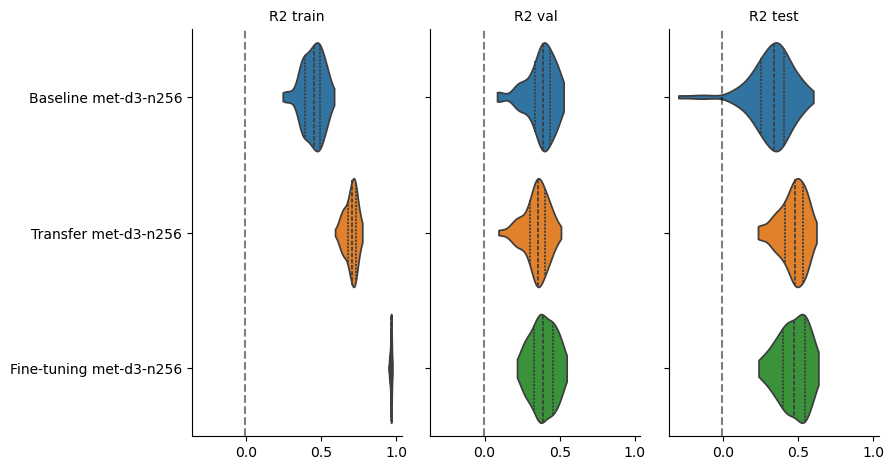

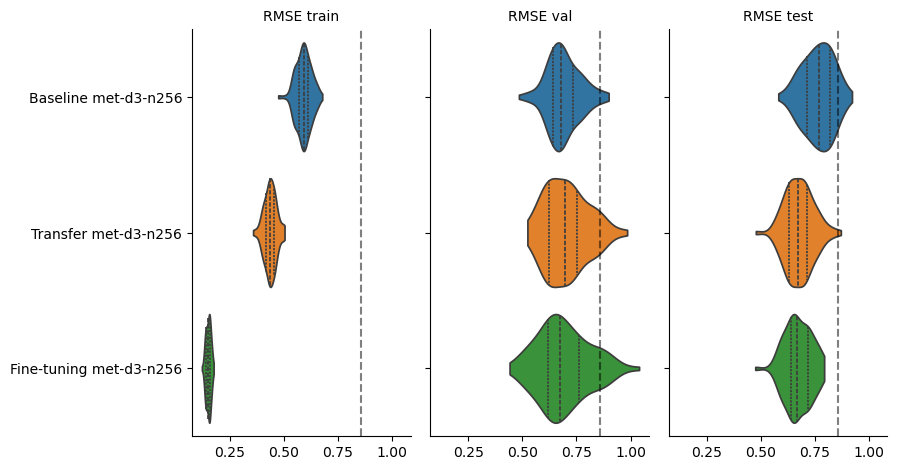

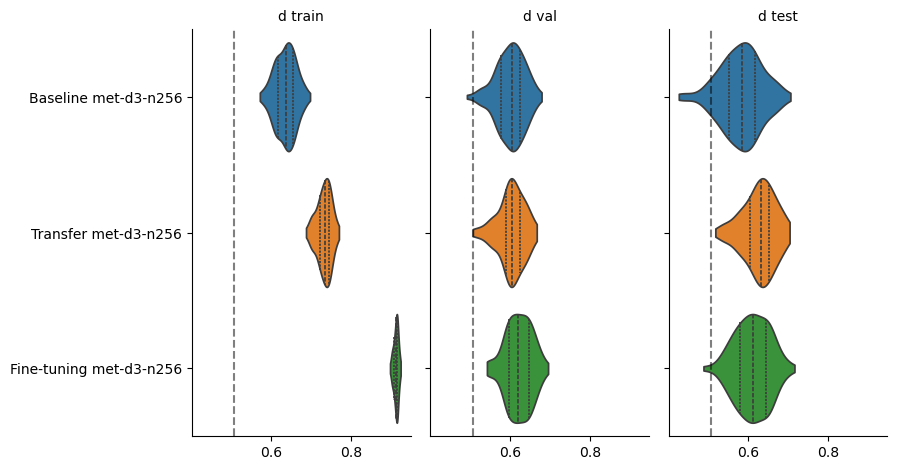

In [73]:
#| label: fig-dtt-boots
#| fig-cap: Scores for all OP~DTT~ embedded met models (+ bootstrap 95% CI)
#| fig-subcap: true

target = "op_dtt25_m3"
metrics = ["R2", "RMSE", "d"]
p = plot_scores_bootstrap(
    dtt_preds.loc["RGB"],
    true_col=target,
    by_model=True,
    scores=metrics,
    seed=SEED,
    kind="violin",
)

In [74]:
#| label: tbl-dtt-boots
#| tbl-cap: Bootstrap-estimated 95% CI of test set scores for OP~DTT~ embedded met models

target = "op_dtt25_m3"
(
    dtt_preds.loc[dtt_preds["set"].eq("test")]
    .loc["RGB"]
    .groupby("model", observed=True, sort=False)
    .apply(bootstrap_scores, true_col=target, n_boot=1000, seed=SEED)
    .groupby("model", observed=True, sort=False)
    .agg([q05, q95])[["R2", "RMSE", "NMAE", "d"]]
    .style.format(precision=2)
    .format("{:.0%}", subset="NMAE")
)

## Scatter

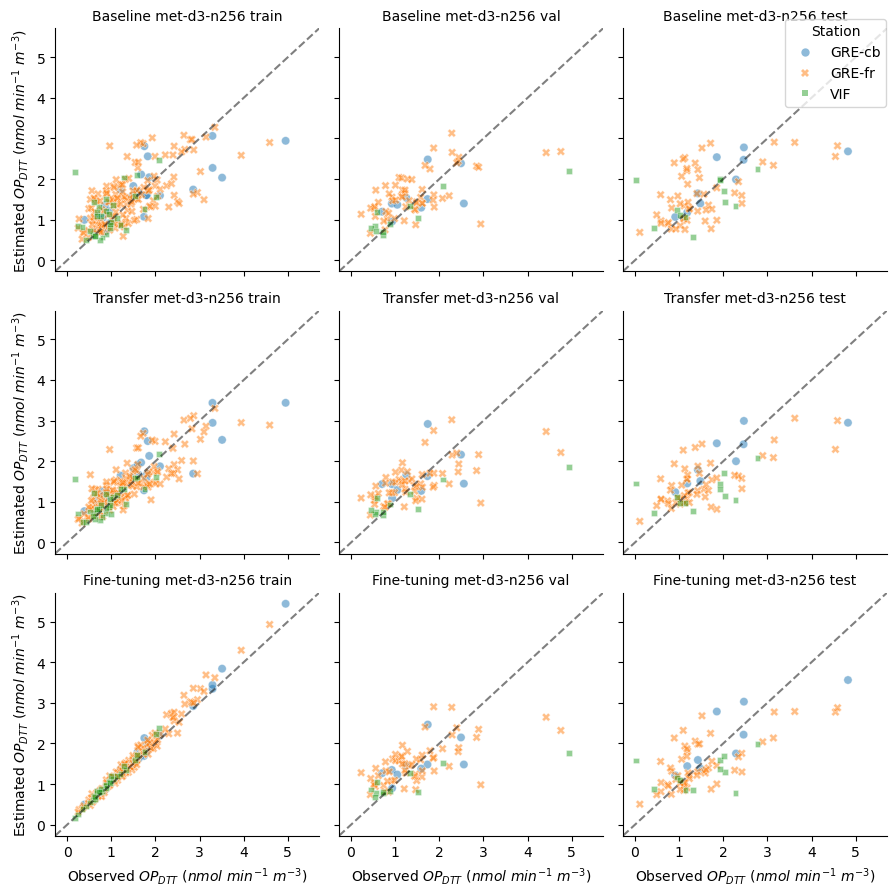

In [75]:
#| label: fig-dtt-scatter
#| fig-cap: Observed and predicted OP~DTT~ from embedded met models

target = "op_dtt25_m3"
p = plot_preds_scatter(
    dtt_preds,
    true_col=target,
    true_desc=f"{target_names[target]} ({target_units[target]})",
    row="model",
    facet_kws=dict(legend_out=False),
    legend=True,
)
p.legend.set(title="Station")
sns.move_legend(p, "upper right", bbox_to_anchor=(0.99, 0.98))

## Loss curves

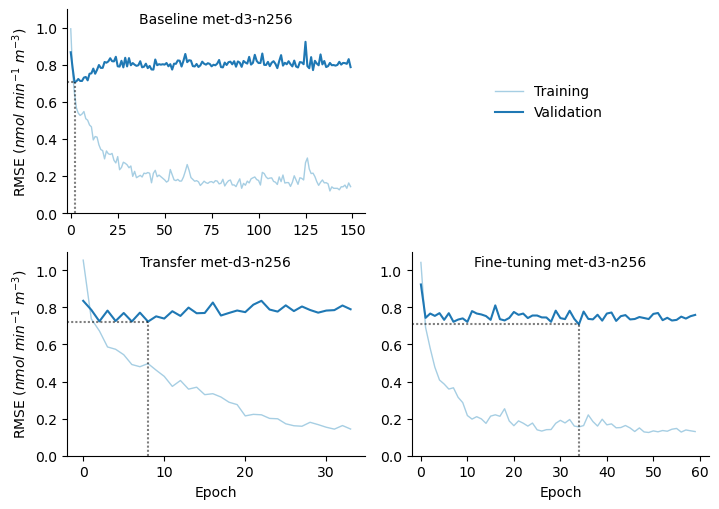

In [76]:
#| label: fig-dtt-loss
#| fig-cap: Training and validation loss from OP~DTT~ embedded met models

# Load training metrics
dtt_loss = load_supervised_metrics(EXPERIMENTS_DIR / "embedding" / "op-dtt25-m3")

# Simplify dataset and backbone names
dtt_loss["dataset"] = dtt_loss["dataset"].str.removesuffix("_PS2_clear")
dtt_loss["backbone"] = dtt_loss["backbone"].str.removesuffix("_RGB")

# Compress version
dtt_loss["version"] = dtt_loss["version"].str.replace("version_", "v")

# Identify models' CNN backbone
dtt_loss = dtt_loss.set_index(["dataset", "backbone", "experiment", "version"])
dtt_loss["CNN"] = None
dtt_loss.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
dtt_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
dtt_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"

# Embedding
dtt_loss["embedding"] = ""
dtt_loss.loc[dtt_loss["hparams"].str.contains("extra-1976"), "embedding"] = "met-d3-n256"

# Name models
dtt_loss["model"] = dtt_loss["CNN"].replace({"None": "Baseline"})
dtt_loss["model"] = dtt_loss["model"] + " " + dtt_loss["embedding"]

# Ensure no unexpected models
if any(dtt_loss["model"].isna()):
    missing = dtt_loss.loc[
        dtt_loss["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
dtt_loss = (
    dtt_loss.reset_index()
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# dtt_loss.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["val_loss"]].count()

# Plot
target = "op_dtt25_m3"
data = dtt_loss.set_index("model").sort_values("epoch")
fig, axs = plt.subplots(2, 2)

plot_loss(axs[0, 0], data.loc["Baseline met-d3-n256"])
axs[0, 1].set_axis_off()
plot_loss(axs[1, 0], data.loc["Transfer met-d3-n256"])
plot_loss(axs[1, 1], data.loc["Fine-tuning met-d3-n256"])

for ax in axs[:, 0]:
    ax.set_ylabel(f"RMSE ({target_units[target]})")

for ax in axs[-1, :]:
    ax.set_xlabel("Epoch")

for i, ax in enumerate(axs.flatten()):
    ylim = (0, 1.1)
    ax.set(
        xlim=(-2, None), ylim=ylim, yticks=np.arange(*ylim, 0.2)
    )

fig.legend(handles=axs[0, 0].lines[0:2], frameon=False, bbox_to_anchor=(0.85, 0.85))

fig.set_figheight(5.2)
fig.set_figwidth(7.3)
fig.tight_layout()

del data

# PM~10~

In [77]:
# ------------------------
# Load and identify models
# ------------------------

# Load preds from all PM models
pm_preds = load_predictions(EXPERIMENTS_DIR / "embedding" / "pm10-imp").dropna()

# Simplify dataset and backbone names
pm_preds["dataset"] = pm_preds["dataset"].str.removesuffix("_PS2_clear")
pm_preds["backbone"] = pm_preds["backbone"].str.removesuffix("_RGB")

# Compress version
pm_preds["version"] = pm_preds["version"].str.replace("version_", "v")

# Identify models' CNN backbone
pm_preds = pm_preds.set_index(["dataset", "backbone", "experiment", "version"])
pm_preds["CNN"] = None
pm_preds.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
pm_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
pm_preds.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"

# Embedding
pm_preds["embedding"] = ""
pm_preds.loc[pm_preds["hparams"].str.contains("extra-1976"), "embedding"] = (
    "met-d3-n256"
)

# Name models
pm_preds["model"] = pm_preds["CNN"].replace({"None": "Baseline"})
pm_preds["model"] = pm_preds["model"] + " " + pm_preds["embedding"]

# Ensure no unexpected models
if any(pm_preds["model"].isna()):
    missing = pm_preds.loc[
        pm_preds["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
pm_preds = (
    pm_preds.reset_index()
    .sort_values("station")
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# pm_preds.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["pred"]].count()

## Scores

In [78]:
#| label: tbl-pm-scores
#| tbl-cap: Scores of PM~10~ embedded met models

target = "pm10_imp"
(
    pm_preds.groupby(["set", "dataset", "model"], sort=False, observed=True)
    .apply(compute_scores, true_col=target)
    .unstack("set")
    .reorder_levels(["set", 0], axis="columns")
    .loc[:, (["train", "val", "test"], ["R2", "RMSE", "NMAE", "d"])]
    .style.format(precision=2)
    .format("{:.0%}", subset=pd.IndexSlice[:, pd.IndexSlice[:, "NMAE"]])
)

## Bootstrap

In [79]:
#| label: fig-pm-boots
#| fig-cap: Scores for all PM~10~ embedded met models (+ bootstrap 95% CI)
#| fig-subcap: true

target = "pm10_imp"
metrics = ["R2", "RMSE", "d"]
p = plot_scores_bootstrap(
    pm_preds.loc["RGB"],
    true_col=target,
    by_model=True,
    scores=metrics,
    seed=SEED,
    kind="violin",
)

In [80]:
#| label: tbl-pm-boots
#| tbl-cap: Bootstrap-estimated 95% CI of test set scores for PM~10~ embedded met models

target = "pm10_imp"
(
    pm_preds.loc[pm_preds["set"].eq("test")]
    .loc["RGB"]
    .groupby("model", observed=True, sort=False)
    .apply(bootstrap_scores, true_col=target, n_boot=1000, seed=SEED)
    .groupby("model", observed=True, sort=False)
    .agg([q05, q95])[["R2", "RMSE", "NMAE", "d"]]
    .style.format(precision=2)
    .format("{:.0%}", subset="NMAE")
)

## Scatter

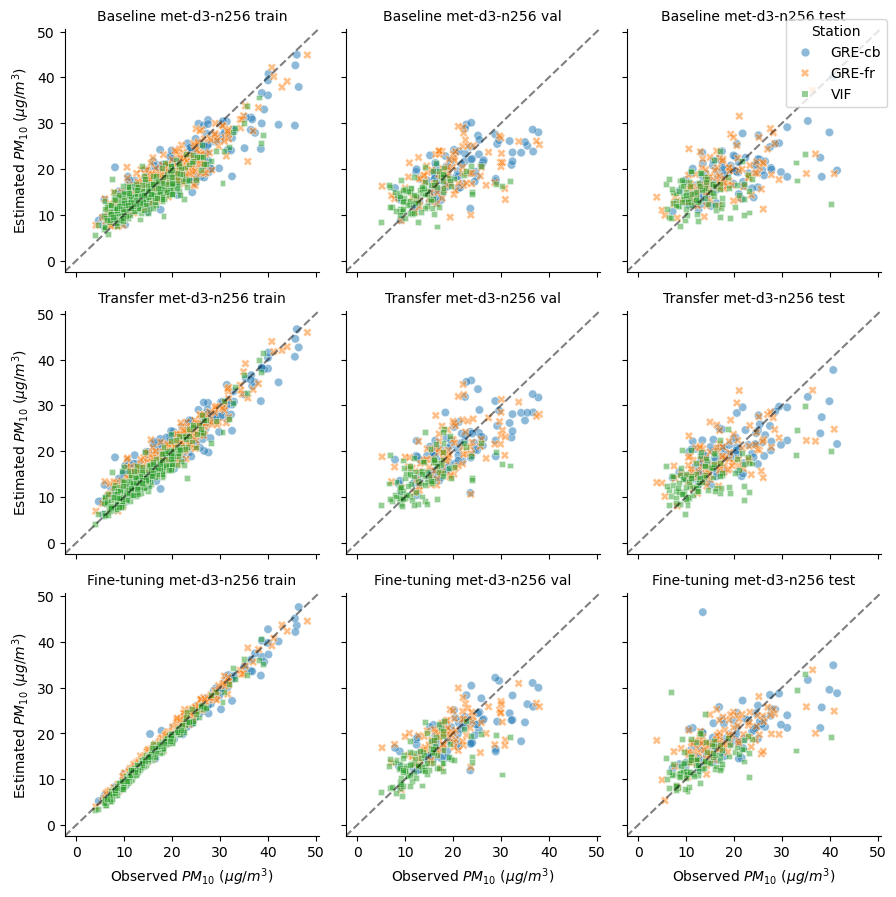

In [81]:
#| label: fig-pm-scatter
#| fig-cap: Observed and predicted P~10~ from embedded met models

target = "pm10_imp"
p = plot_preds_scatter(
    pm_preds,
    true_col=target,
    true_desc=f"{target_names[target]} ({target_units[target]})",
    row="model",
    facet_kws=dict(legend_out=False),
    legend=True,
)
p.legend.set(title="Station")
sns.move_legend(p, "upper right", bbox_to_anchor=(0.99, 0.98))

## Loss curves

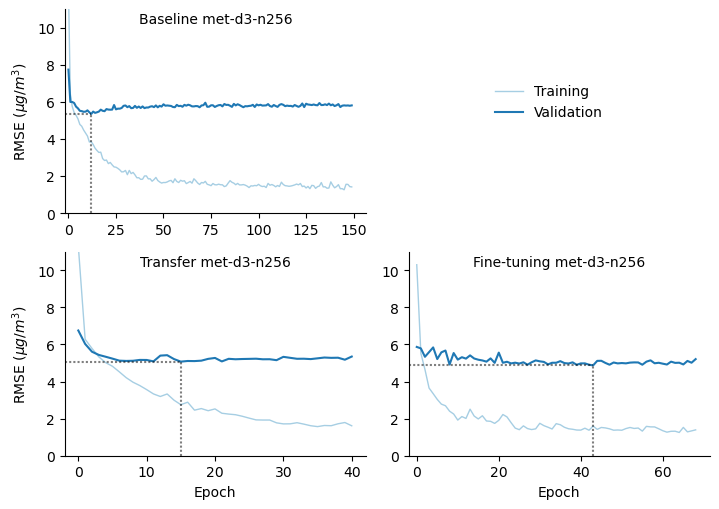

In [82]:
#| label: fig-pm-loss
#| fig-cap: Training and validation loss from PM~10~ embedded met models

# Load training metrics
pm_loss = load_supervised_metrics(EXPERIMENTS_DIR / "embedding" / "pm10-imp")

# Simplify dataset and backbone names
pm_loss["dataset"] = pm_loss["dataset"].str.removesuffix("_PS2_clear")
pm_loss["backbone"] = pm_loss["backbone"].str.removesuffix("_RGB")

# Compress version
pm_loss["version"] = pm_loss["version"].str.replace("version_", "v")

# Identify models' CNN backbone
pm_loss = pm_loss.set_index(["dataset", "backbone", "experiment", "version"])
pm_loss["CNN"] = None
pm_loss.loc[pd.IndexSlice[:, "nocnn", "exp01", "v0"], "CNN"] = "None"
pm_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp01", "v0"], "CNN"] = "Transfer"
pm_loss.loc[pd.IndexSlice[:, "IMAGENET1K-V2", "exp02", "v0"], "CNN"] = "Fine-tuning"

# Embedding
pm_loss["embedding"] = ""
pm_loss.loc[pm_loss["hparams"].str.contains("extra-1976"), "embedding"] = "met-d3-n256"

# Name models
pm_loss["model"] = pm_loss["CNN"].replace({"None": "Baseline"})
pm_loss["model"] = pm_loss["model"] + " " + pm_loss["embedding"]

# Ensure no unexpected models
if any(pm_loss["model"].isna()):
    missing = pm_loss.loc[
        pm_loss["model"].isna(), ["backbone", "experiment", "version", "hparams"]
    ].unique()
    raise ValueError(f"Unrecognized backbone: {missing}")

# Sort models
pm_loss = (
    pm_loss.reset_index()
    .set_index(["dataset", "CNN", "embedding"])
    .loc[
        [
            ("RGB", "None", "met-d3-n256"),
            ("RGB", "Transfer", "met-d3-n256"),
            ("RGB", "Fine-tuning", "met-d3-n256"),
        ]
    ]
    .reset_index(["CNN", "embedding"])
)

# pm_loss.groupby(
#     ["dataset", "CNN", "model", "embedding", "backbone", "experiment", "version"],
#     sort=False,
# )[["val_loss"]].count()

# Plot
target = "pm10_imp"
data = pm_loss.set_index("model").sort_values("epoch")
fig, axs = plt.subplots(2, 2)

plot_loss(axs[0, 0], data.loc["Baseline met-d3-n256"])
axs[0, 1].set_axis_off()
plot_loss(axs[1, 0], data.loc["Transfer met-d3-n256"])
plot_loss(axs[1, 1], data.loc["Fine-tuning met-d3-n256"])

for ax in axs[:, 0]:
    ax.set_ylabel(f"RMSE ({target_units[target]})")

for ax in axs[-1, :]:
    ax.set_xlabel("Epoch")

for i, ax in enumerate(axs.flatten()):
    ylim = (0, 11)
    ax.set(
        xlim=(-2, None), ylim=ylim, yticks=np.arange(*ylim, 2)
    )

fig.legend(handles=axs[0, 0].lines[0:2], frameon=False, bbox_to_anchor=(0.85, 0.85))

fig.set_figheight(5.2)
fig.set_figwidth(7.3)
fig.tight_layout()

del data